## Are the music genres similar between friends? (Part 2)

In notebook 2, we'll try to build a model to predict which user a song should belong to, which contains the following steps:

1. **Feature engineering** (standardization)
2. **Logistic regression** model
3. **Random forest** classifier
4. **Hyperparameters tuning**
5. Conclusions

### 1. Feature engineering

In [1]:
# Import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

UserA = pd.read_csv("fm12z8ig3mo6s9axre6049m5h-1vgZmbngUv9YFEsz3AB18e.csv") # Me (Connie)
UserB = pd.read_csv("21hi7kguws4venzuqvqs4lska-6KeEoUTI2bbmOoK7McTrLF.csv") # My friend Cindy

In [2]:
# Label: user
UserA['user'] = 0 #'Connie'
UserB['user'] = 1 #'Cindy'

In [3]:
# Stack the DataFrames on top of each other
dup_data = pd.concat([UserA, UserB], axis=0)
len(dup_data)

1851

In [4]:
# Drop if the song exists more than once in the same user's playlist (duplicated)
_nondup_data = dup_data[dup_data.duplicated(subset=['uri','user'], keep='first')==False]
len(_nondup_data)

1850

In [5]:
# Drop if the song exists in both playlists (cannot classify which user in this case)
nondup_data = _nondup_data[_nondup_data.duplicated(subset='uri', keep=False)==False]
nondup_data
len(nondup_data)

## 25 songs are duplicated

1800

In [6]:
# Drop variables with unclear definition or useless in classification
data = nondup_data.drop(['time_signature', 'type', 'uri'], axis=1)

In [7]:
data.dtypes

energy              float64
liveness            float64
tempo               float64
speechiness         float64
acousticness        float64
instrumentalness    float64
danceability        float64
key                   int64
duration_ms           int64
loudness            float64
valence             float64
mode                  int64
user                  int64
dtype: object

In [8]:
# key & mode should be categorical data
data[['key','mode']] = data[['key','mode']].astype('object')

In [9]:
data.dtypes

energy              float64
liveness            float64
tempo               float64
speechiness         float64
acousticness        float64
instrumentalness    float64
danceability        float64
key                  object
duration_ms           int64
loudness            float64
valence             float64
mode                 object
user                  int64
dtype: object

In [10]:
data.describe()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,user
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.00000,1800.000000,1800.000000,1800.000000
mean,0.684230,0.180923,125.147728,0.062147,0.253015,0.039241,0.572481,234737.06000,-6.146296,0.489918,0.702222
std,0.215285,0.133010,29.315588,0.050013,0.280382,0.161660,0.133929,49559.66298,3.365436,0.226472,0.457408
min,0.008500,0.017600,46.168000,0.023200,0.000010,0.000000,0.103000,50280.00000,-34.218000,0.030500,0.000000
25%,0.540750,0.096125,100.065250,0.034000,0.024175,0.000000,0.488750,203545.75000,-7.376000,0.308000,0.000000
50%,0.726000,0.127000,124.966000,0.044900,0.131000,0.000000,0.575500,231855.00000,-5.462500,0.482000,1.000000
75%,0.861000,0.247250,142.962500,0.067800,0.404000,0.000152,0.672000,265013.25000,-4.082250,0.661000,1.000000
max,0.996000,0.971000,220.210000,0.474000,0.995000,0.978000,0.930000,534120.00000,-0.227000,0.982000,1.000000


In [11]:
# Check if there is missing data
data.isna().sum()

energy              0
liveness            0
tempo               0
speechiness         0
acousticness        0
instrumentalness    0
danceability        0
key                 0
duration_ms         0
loudness            0
valence             0
mode                0
user                0
dtype: int64

#### ***Be sure to consider dropping the rows with no labels

In [12]:
# Split into X & y
X = data.drop('user', axis=1)
y = data['user']

In [13]:
X.head()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,key,duration_ms,loudness,valence,mode
0,0.825,0.0936,118.091,0.0325,0.02150,0.000024,0.650,0,191014,-4.645,0.593,1
1,0.864,0.0389,106.005,0.0652,0.00327,0.000000,0.697,10,199013,-4.344,0.808,1
2,0.715,0.2880,159.975,0.0636,0.34700,0.013600,0.559,5,198210,-3.773,0.335,1
3,0.706,0.0640,142.989,0.1600,0.22300,0.000280,0.766,7,172598,-6.553,0.766,0
5,0.683,0.1250,108.003,0.0253,0.00382,0.000002,0.610,2,241693,-3.879,0.466,0


In [14]:
y.head()

0    0
1    0
2    0
3    0
5    0
Name: user, dtype: int64

In [15]:
# Split data into train and test
from sklearn.model_selection import train_test_split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1440, 12), (360, 12), (1440,), (360,))

In [17]:
# Check missing values
X.isna().sum()

energy              0
liveness            0
tempo               0
speechiness         0
acousticness        0
instrumentalness    0
danceability        0
key                 0
duration_ms         0
loudness            0
valence             0
mode                0
dtype: int64

#### ***If there are missing data => consider the imputation separately in training set and testing set

In [18]:
# Turn the categories into numbers
X_train_dummies = pd.get_dummies(data=X_train, columns=['key','mode']).reset_index()
X_test_dummies = pd.get_dummies(data=X_test, columns=['key','mode']).reset_index()
X_train_dummies.dtypes

index                 int64
energy              float64
liveness            float64
tempo               float64
speechiness         float64
acousticness        float64
instrumentalness    float64
danceability        float64
duration_ms           int64
loudness            float64
valence             float64
key_0                 uint8
key_1                 uint8
key_2                 uint8
key_3                 uint8
key_4                 uint8
key_5                 uint8
key_6                 uint8
key_7                 uint8
key_8                 uint8
key_9                 uint8
key_10                uint8
key_11                uint8
mode_0                uint8
mode_1                uint8
dtype: object

In [19]:
X_train_dummies.head()

,index,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1
0,304,0.943,0.1020,128.994,0.0479,0.11700,0.000006,0.582,174304,-3.855,...,0,0,0,0,0,0,0,0,0,1
1,308,0.881,0.0802,165.064,0.0396,0.10700,0.382000,0.519,274909,-8.133,...,0,0,0,1,0,0,0,0,0,1
2,584,0.611,0.2460,118.020,0.0422,0.00363,0.000000,0.769,193493,-5.674,...,0,0,0,0,1,0,0,0,0,1
3,331,0.938,0.3600,128.009,0.0663,0.35600,0.000000,0.702,246438,-2.718,...,0,0,0,0,0,0,0,1,0,1
4,33,0.852,0.0991,147.997,0.0881,0.09430,0.000002,0.606,208991,-4.996,...,0,0,0,0,0,0,0,0,0,1


In [20]:
X_train_dummies.columns

Index(['index', 'energy', 'liveness', 'tempo', 'speechiness', 'acousticness',
       'instrumentalness', 'danceability', 'duration_ms', 'loudness',
       'valence', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5',
       'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'mode_0',
       'mode_1'],
      dtype='object')

### Standardization

In [21]:
# Standardization  
from sklearn.preprocessing import StandardScaler
numerical_features = ['energy', 'liveness', 'tempo', 'speechiness', 'acousticness', 
                      'instrumentalness', 'danceability', 'duration_ms', 'loudness', 'valence']

std_scaler = StandardScaler()

x = X_train_dummies[numerical_features]
x_scaled = std_scaler.fit_transform(x)
X_train_std = pd.DataFrame(x_scaled, columns=x.columns)
x_rest_col = list(X_train_dummies.drop(numerical_features, axis=1).columns)
X_train_std[x_rest_col] = X_train_dummies[x_rest_col]

In [22]:
xt = X_test_dummies[numerical_features]
xt_scaled = std_scaler.transform(xt)
X_test_std = pd.DataFrame(xt_scaled, columns=xt.columns)
xt_rest_col = list(X_test_dummies.drop(numerical_features, axis=1).columns)
X_test_std[xt_rest_col] = X_test_dummies[xt_rest_col]

In [23]:
X_train_std.head()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1
0,1.208908,-0.597926,0.133323,-0.282235,-0.491922,-0.241685,0.094215,-1.227848,0.691935,1.275662,...,0,0,0,0,0,0,0,0,0,1
1,0.919008,-0.764635,1.358836,-0.449695,-0.528000,2.158540,-0.377275,0.808065,-0.609163,-1.451176,...,0,0,0,1,0,0,0,0,0,1
2,-0.343463,0.503271,-0.239529,-0.397238,-0.900936,-0.241725,1.493717,-0.839526,0.138709,1.160193,...,0,0,0,0,1,0,0,0,0,1
3,1.185529,1.375052,0.099857,0.089003,0.370337,-0.241725,0.992291,0.231906,1.037738,2.088384,...,0,0,0,0,0,0,0,1,0,1
4,0.783409,-0.620103,0.778969,0.528838,-0.573819,-0.241713,0.273830,-0.525897,0.344914,0.152062,...,0,0,0,0,0,0,0,0,0,1


In [24]:
X_test_std.head()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1
0,0.867574,0.411504,0.302999,-0.278200,-0.705142,-0.241717,0.386090,0.482072,0.373503,0.560644,...,0,0,0,0,0,1,0,0,0,1
1,1.017200,0.487976,0.233009,-0.463818,-0.325964,-0.241725,0.041827,-0.277755,1.608299,1.275662,...,0,0,0,0,0,0,0,1,1,0
2,1.222936,1.344463,-1.189225,1.777729,-0.910738,-0.212696,-1.275352,0.185807,0.831229,0.045476,...,0,0,0,0,0,0,0,1,1,0
3,-0.656742,-0.597926,0.847634,-0.655490,-0.419767,-0.241578,-0.085400,1.861730,-0.047422,-0.407517,...,0,0,0,0,0,0,1,0,0,1
4,-0.530495,-0.654516,0.166110,-0.588909,-0.012088,-0.241725,0.423510,0.862988,-0.404783,-1.455617,...,0,0,0,1,0,0,0,0,1,0


### 2. Logistic regression model

In [25]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [26]:
# Confusion matrix & ROC curve
def conf_mat_and_roc(conf_mat, fpr, tpr):
    
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    plt.subplot(1, 2, 1)
    import seaborn as sns
    sns.set(font_scale=1.5) # Set the font scale 
    sns.heatmap(conf_mat,
                 annot=True, # Annotate the boxes with conf_mat info
                 fmt='.20g',
                 cbar=False);

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    
    
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='')

    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [27]:
def predict(model, X_train, X_test):
    from sklearn.model_selection import cross_val_score

    if model == 'LogisticRegression':
        from sklearn import linear_model
        clf = linear_model.LogisticRegression(max_iter=500)

    elif model == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=100)
    else:
        print('Wrong model')

    # Setup random seed
    np.random.seed(42)

    # Fit the model
    clf.fit(X_train, y_train)

    # Make predictions with probabilities
    y_probs = clf.predict_proba(X_test)

    # Make predictions
    y_preds = clf.predict(X_test)

    # Evaluate the model
    evaluate_preds(y_test, y_preds)
    
    from sklearn.metrics import roc_curve
    # Make predictions with probabilities
    y_probs = clf.predict_proba(X_test)
    y_probs_positive = y_probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)
    
    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(y_test, y_preds)
    
    #return y_preds, y_probs, fpr, tpr, conf_mat;
    conf_mat_and_roc(conf_mat, fpr, tpr)
    
    from sklearn.metrics import roc_auc_score
    print(f'AUC: {roc_auc_score(y_test, y_probs_positive)}')

### 2-1. Logistic regression model (fit the model before scaling X)

Accuracy: 66.11%
Precision: 0.72
Recall: 0.83
F1 score: 0.77


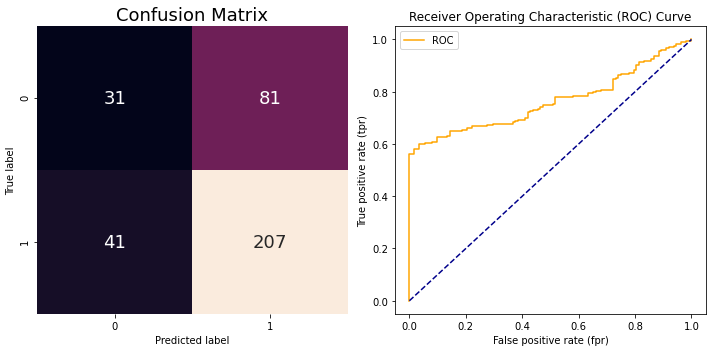

AUC: 0.7637168778801844


In [28]:
predict(model='LogisticRegression',  X_train=X_train_dummies, X_test=X_test_dummies)

### 2-2. Logistic regression model (fit the model after scaling X)

Accuracy: 78.89%
Precision: 0.82
Recall: 0.88
F1 score: 0.85


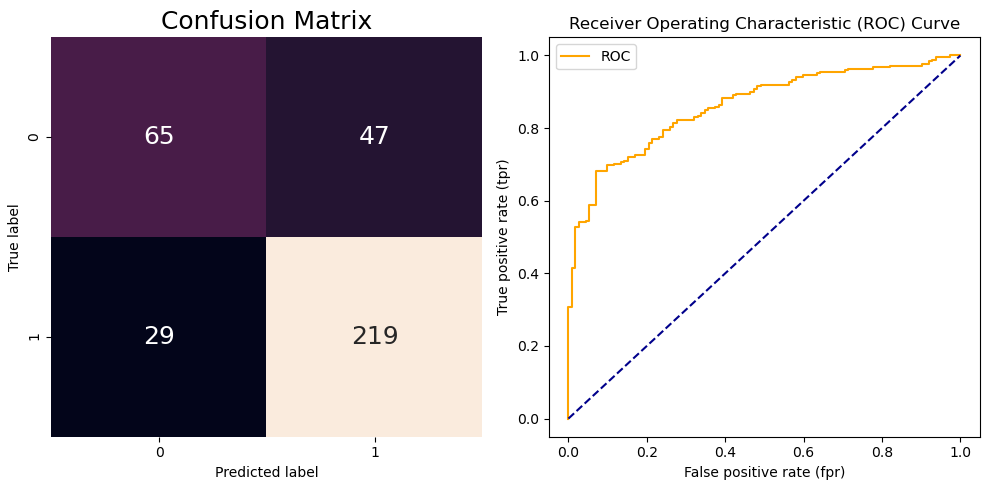

AUC: 0.8608870967741935


In [29]:
predict(model='LogisticRegression',  X_train=X_train_std, X_test=X_test_std)

**Standardization can improve the performance of logistic regression!**

### 3. Random forest classifier
### 3-1. Random forest classifier (fit the model before scaling X)

Accuracy: 83.61%
Precision: 0.85
Recall: 0.92
F1 score: 0.89


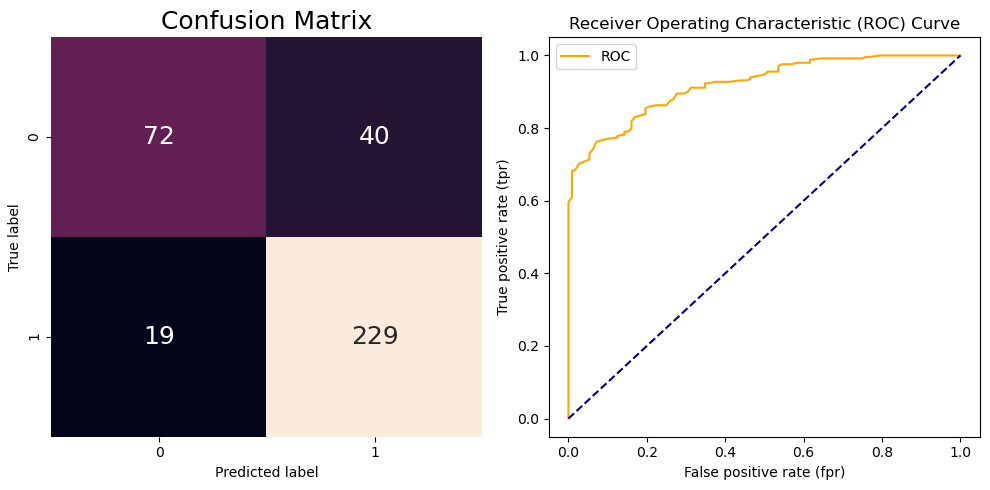

AUC: 0.9199488767281105


In [30]:
predict(model='RandomForestClassifier',  X_train=X_train_dummies, X_test=X_test_dummies)

### 3-2. Random forest classifier (fit the model after scaling X)

Accuracy: 83.06%
Precision: 0.85
Recall: 0.92
F1 score: 0.88


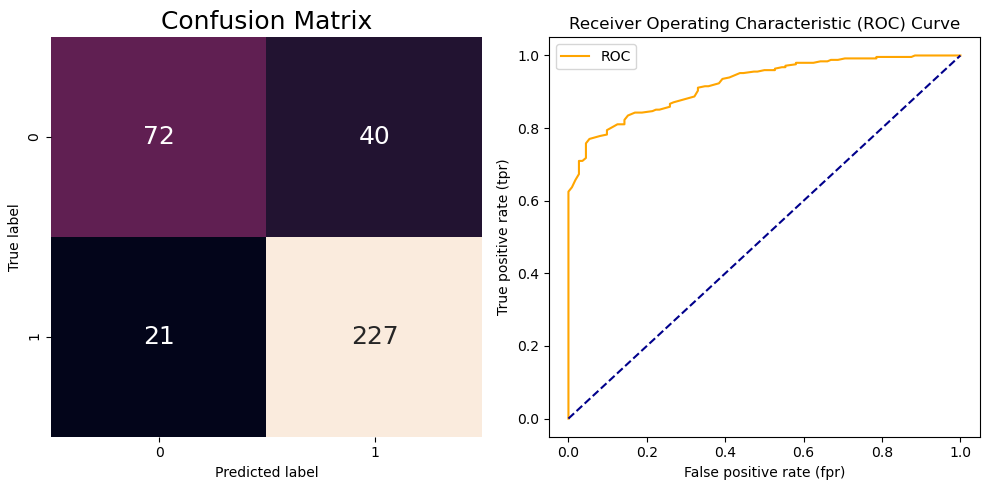

AUC: 0.9218930011520736


In [31]:
predict(model='RandomForestClassifier',  X_train=X_train_std, X_test=X_test_std)

**Scaling is not necessary for random forest classifier.**

### 4. Hyperparameters tuning
### 4-1. RandomizedSearchCV

In [32]:
from sklearn.model_selection import RandomizedSearchCV

# Define a grid of hyperparameters
grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["auto", "sqrt"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=1)

# Setup RandomizedSearchCV
rs_clf = RandomizedSearchCV(estimator=clf,
                            param_distributions=grid,
                            n_iter=10, # try 10 models total
                            cv=5, # 5-fold cross-validation
                            verbose=2) # print out results

# Fit the RandomizedSearchCV version of clf
rs_clf.fit(X_train_std, y_train);

# Find the best hyperparameters
print(rs_clf.best_params_)

# Scoring automatically uses the best hyperparameters
rs_clf.score(X_test_std, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   5.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   5.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; 

0.8361111111111111

In [33]:
rs_clf.best_params_

{'n_estimators': 1000,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None}

In [34]:
# Make predictions with the best hyperparameters
rs_y_preds = rs_clf.predict(X_test_std)

# Evaluate the predictions
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Accuracy: 83.61%
Precision: 0.85
Recall: 0.92
F1 score: 0.89


### 4-2. GridSearchCV

In [35]:
grid_2 = {'n_estimators': [100, 1000],
          'max_depth': [None],
          'max_features': ['auto', 'sqrt'],
          'min_samples_split': [4],
          'min_samples_leaf': [1, 2]}

In [36]:
from sklearn.model_selection import GridSearchCV

np.random.seed(42)

# Instantiate RandomForestClassifier
clf = RandomForestClassifier(n_jobs=1)

# Setup GridSearchCV
gs_clf = GridSearchCV(estimator=clf,
                      param_grid=grid_2, 
                      cv=5,
                      verbose=2)

# Fit the GridSearchCV version of clf
gs_clf.fit(X_train_std, y_train);

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time=   4.9s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time=   5.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4,

In [37]:
gs_clf.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1000}

In [38]:
gs_y_preds = gs_clf.predict(X_test_std)

# evaluate the predictions
gs_metrics = evaluate_preds(y_test, gs_y_preds)

Accuracy: 83.61%
Precision: 0.85
Recall: 0.93
F1 score: 0.89


### 5. Conclusions

* Based on the findings in notebook 1, **there were only 25 songs repeated in my playlist and Cindy's playlist, which stands a very small percent of our liked songs in playlist.** However, **our songs do have very similar audio features: most of them tend to be energetic and suitable for dancing.** 
* Findings in Notebook 2:
    - I trained a machine learning model (random forest classifier) with the purpose of predicting if a song should belong to my playlist or Cindy's playlist. **The accuracy of the model was 83.61%, F1 score = 0.89, which is pretty good.**
    - I have to drop songs that were added to both of our playlists in this classification project.
    - After dropping 25 repeated songs in our playlists, **there are 536 songs in my playlist and 1264 songs in Cindy's playlist.** Due to the **imbalanced data**, when considering the metrics of the model performance, I value Precision/Recall/F1 score more than Accuracy. 
    - **Standardization can improve the performance of logistic regression.**
    - **Scaling is not necessary for random forest classifier.**
    - Future topics: 
      1. How to better handle imbalanced data
      2. Multicollinearity